In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# 超参数
batch_size = 32
block_size = 64 # 相当于sequence_len
n_embedding = 64
dropout = 0.2
num_layers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# 读取数据
with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {char: index for index, char in enumerate(chars)}
itos = {index: char for index, char in enumerate(chars)}
encode = lambda sentence: [stoi[char] for char in sentence]
decode = lambda index_list: "".join([itos[index] for index in index_list])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == "train" else val_data
    idx = torch.randint(0, len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in idx])
    y = torch.stack([data[i+1:i+block_size+1] for i in idx])
    return x, y

In [10]:
class Head(nn.Module):
    def __init__(self, head_dimension):
        super().__init__()
        self.key = nn.Linear(n_embedding, head_dimension, bias=False)
        self.query = nn.Linear(n_embedding, head_dimension, bias=False)
        self.value = nn.Linear(n_embedding, head_dimension, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x): # 输入 x - (batch_size, block_size, embedding_size)
        B, T, _ = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x) # v - (batch_size, block_size, head_dimension)
        wei = q @ k.transpose(-2, -1)
        tril = torch.tril(torch.ones(T, T))
        wei = wei.masked_fill(tril==0, float("-inf"))
        wei = F.softmax(wei, dim=-1) # wei - (batch_size, block_size, block_size)
        wei = self.dropout(wei)
        out = wei @ v
        return out # out - (batch_size, block_size, head_dimension)

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_dimension):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_dimension) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_dimension, n_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1) # out - (batch_size, block_size, head_dimension * num_heads)
        out = self.proj(out) # out - (batch_size, block_size, n_embedding)
        out = self.dropout(out)
        return out

In [12]:
class FeedForward(nn.Module):
    def __init__(self, n_embedding):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embedding, 4 * n_embedding),
            nn.ReLU(),
            nn.Linear(4 * n_embedding, n_embedding),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [13]:
class Block(nn.Module):
    def __init__(self, n_embedding, num_heads):
        super().__init__()
        head_dimension = n_embedding // num_heads
        self.sa = MultiHeadAttention(num_heads, head_dimension)
        self.ffwd = FeedForward(n_embedding)
        self.ln1 = nn.LayerNorm(n_embedding)
        self.ln2 = nn.LayerNorm(n_embedding)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class miniGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embedding)
        self.position_embedding_table = nn.Embedding(block_size, n_embedding)
        self.blocks = nn.Sequential(
            *[Block(n_embedding, 8) for _ in range(num_layers)],
            nn.LayerNorm(n_embedding)
        )
        self.output_projection = nn.Linear(n_embedding, vocab_size)

    def forward(self, x, target=None): # x - (batch_size, block_size)
        token_embedding = self.token_embedding_table(x) # token_embedding - (batch_size, block_size, embedding_size)
        position_embedding = self.position_embedding_table(torch.arange(x.shape[1], device=device)) # position_embedding - (block_size, embedding_size)
        input = token_embedding + position_embedding # input - (batch_size, block_size, embedding_size)
        out = self.blocks(input)
        logits = self.output_projection(out) # logits - (batch_size, block_size, vocab_size)
        if target == None:
            loss = None
        else:
            batch, block, vocab = logits.shape
            logits = logits.view(batch * block, vocab)
            target = target.view(batch * block)
            loss = F.cross_entropy(logits, target)
        return logits, loss
    
    def generate(self, x, max_new_token): # x - (1, block_size)
        for _ in range(max_new_token):
            logits, loss = self(x) # logits - (1, block_size, vocab_size)
            logits = logits[:, -1, :] # logits - (1, vocab_size)
            probs = F.softmax(logits, dim=1) # probs - (1, vocab_size)
            next_token = torch.multinomial(probs, num_samples=1) # next_token - (1, 1)
            x = torch.cat((x, next_token), dim=1) # x - (1, block_size + 1)
        return x # x - (1, block_size + max_new_token)

In [ ]:
from tqdm import tqdm
# 超参数再定义一遍
batch_size = 32
block_size = 64 # 相当于sequence_len
n_embedding = 64
dropout = 0.2
num_layers = 4
lr = 3e-4
epochs = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

minigpt = miniGPT()
optimizer = torch.optim.AdamW(minigpt.parameters(), lr=lr)

# training and validation
minigpt.to(device)
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    minigpt.train()
    xb, yb = get_batch("train")
    xb, yb = xb.to(device), yb.to(device)
    logits, train_loss = minigpt(xb, yb)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    minigpt.eval()
    xb, yb = get_batch("validation")
    xb, yb = xb.to(device), yb.to(device)
    logits, val_loss = minigpt(xb, yb)

    train_loss_list.append(train_loss.item())
    val_loss_list.append(val_loss.item())
    print(f"Epoch:{epoch + 1}, training loss:{train_loss.item():.4f}, validation loss:{val_loss.item():.4f}")


`Epoch:1000, training loss:2.4449, validation loss:2.3636`

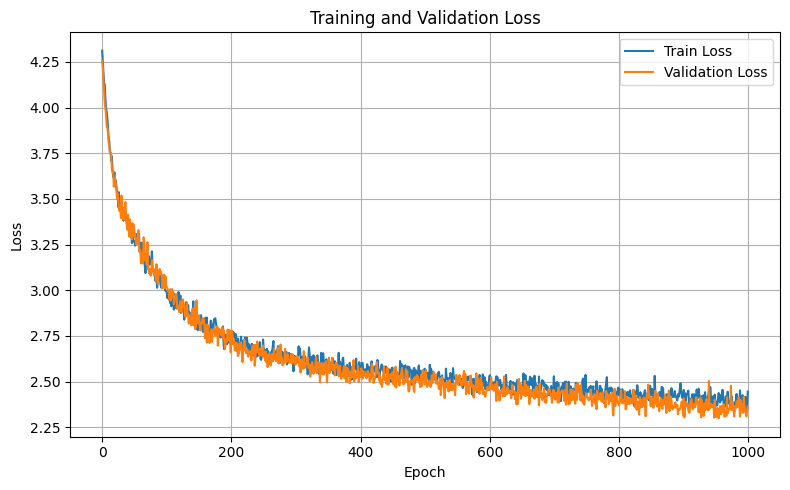

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
start_text = "ROMEO:"
start_ids = torch.tensor([encode(start_text)], dtype=torch.long)
output = minigpt.generate(start_ids, 58)[0].tolist()
print(decode(output))

ROMEO:
Suay, ichshenthe be ziceed silsre t ar fres Vsorallseandi
